In [2]:
#imports 
import cv2 
import matplotlib.pyplot as plt
import numpy as np
from skimage.draw import line


# Reading map

(400, 680, 3)


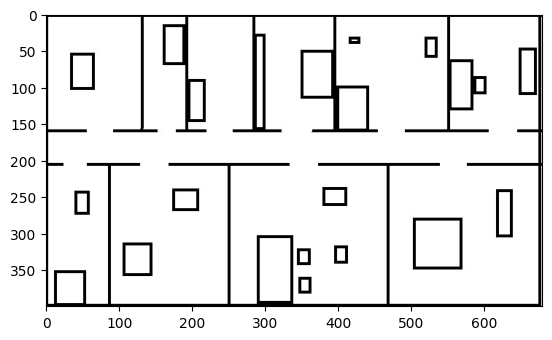

In [3]:
#read the map
map=cv2.imread('./Map.jpg')
#convert to grayscale
map=cv2.cvtColor(map, cv2.COLOR_BGR2RGB)
#make map black and white
print(map.shape)
# print(map)
# map[100][100:104]=(255,0,0)
# map[101][100:104]=(255,0,0)
# map[102][100:104]=(255,0,0)
# map[103][100:104]=(255,0,0)
#show the map
plt.imshow(map)


# Problem 1

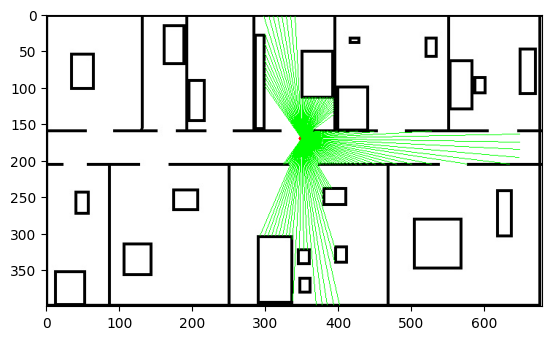

In [61]:
distances=[]
def draw_rays(x,y,theta,max_measurement=1200,map=map,opening_angle=250,step=2):
    max_measurement = max_measurement//4
    # map[y][x:x+4]=(255,0,0)
    # map[y+1][x:x+4]=(255,0,0)
    # map[y+2][x:x+4]=(255,0,0)
    # map[y+3][x:x+4]=(255,0,0)
    cv2.circle(map,(x,y),4,(255,0,0),thickness=-4)
    for i in range(-opening_angle//2,(opening_angle//2)+1,step):
        end_x = int(x + max_measurement * np.cos(np.radians(theta + i)))
        end_y = int(y + max_measurement * np.sin(np.radians(theta + i)))
        #draw line
        pixelx,pixely=line(x,y,end_x,end_y)
        # print(pixelx)
        # print(pixely)
        for index_x,index_y in zip(pixelx,pixely):
            if index_x>=0 and index_x<map.shape[1] and index_y>=0 and index_y<map.shape[0]:
                # print((map[index_x][index_y]))
                if np.array_equal(map[index_y, index_x], [0, 0, 0]):
                    end_x=index_x
                    end_y=index_y
                    break
        
        cv2.line(map,(x,y),(end_x,end_y),(0,255,0),1)
        distances.append(np.sqrt((end_x-x)**2+(end_y-y)**2))   
    return map
map=cv2.imread('./Map.jpg')
map = draw_rays(350, 170, 0, map=map)
plt.imshow(map)

# Problem 2

0.00392156862745098


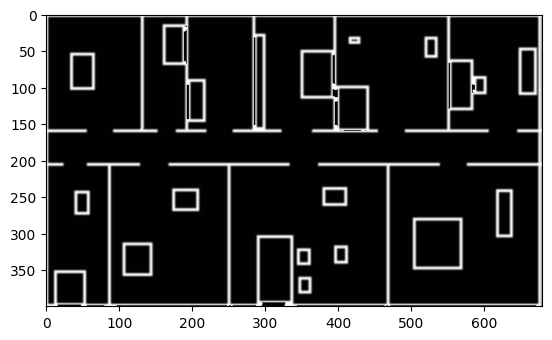

In [62]:
#preparing the map to be like the likelihood field
# converting white to black and vice versa
map=cv2.imread('./Map.jpg')
map=cv2.cvtColor(map, cv2.COLOR_BGR2GRAY)
map=255-map
#want to convert it to grayscale
map=cv2.GaussianBlur(map,(5,5),0)
map+=1
map=map/255
#convert to grayscale
print(map[100][100])
plt.imshow(map,cmap='gray')
# np.max(map)

1 0 0


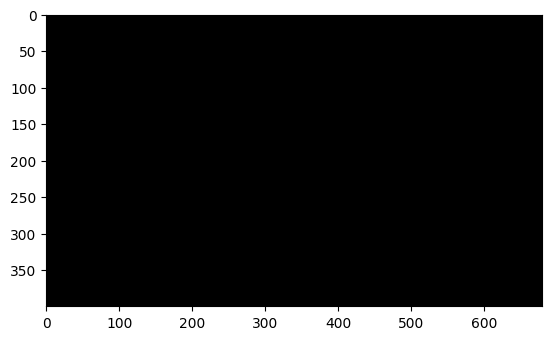

In [66]:
def find_robot_pose(map,distances):
    position_x=0
    position_y=0
    orientation=0
    max_probablity_for_theta=[]
    for y in range(0,map.shape[0],5):
        for x in range(0,map.shape[1],5):
            all_theta_probablities=[]
            for theta in range(0,360,2):
                probablities=[]
                #vectorize the code
                end_x = ((x*4 + np.array(distances) * np.cos(np.radians(theta)))//4).astype(int)
                end_y = ((y*4 + np.array(distances) * np.sin(np.radians(theta)))//4).astype(int)
                if np.any(end_y>=map.shape[0]) or np.any(end_x>=map.shape[1] ) or np.any(end_y<0) or np.any(end_x<0) :
                    probablities.append(0.00001)
                    continue
                #multiply all probablities of map[end_y,end_x] for all end_x and end_y using vectorization                
                probablities=map[end_y,end_x]
                
                # print(len(probablities))
            #multiply all probablities with each  other
                theta_probablity=np.prod(probablities)
                all_theta_probablities.append(theta_probablity)
            #find the max probablity
            max_probablity_for_theta.append(max(all_theta_probablities))
            map[y][x]=max(all_theta_probablities)
            max_probablity=max(max_probablity_for_theta)
            #find the position
    position_y,position_x=np.unravel_index(np.argmax(map),map.shape)
    
            # map[y][x]=max_probablity
            # position_x=x
            # position_y=y
    # orientation=all_theta_probablities.index(max_probablity)*2
    print(position_x,position_y,orientation)
    
    position_p=np.zeros((map.shape[0],map.shape[1]))
    position_p[position_y,position_x]=255
    
    return map,position_p
map,position=find_robot_pose(map,distances)
plt.imshow(map,cmap='gray')
plt.imshow(position,cmap='gray')


255.0
1 0


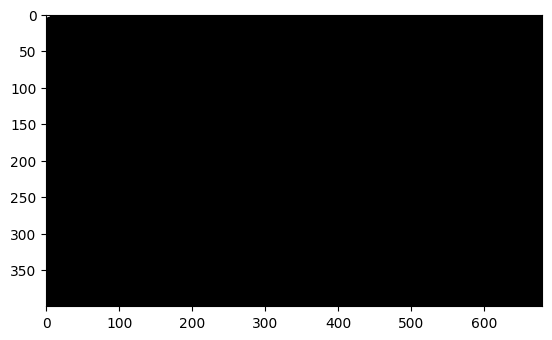

In [67]:
# print(map.shape)
#max of the map
# Dilate image
circle_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9 ,9))
# Dilate the image using the circular structuring element
dilated_image = cv2.dilate(position, circle_kernel)
print(np.max(position))
y,x=np.unravel_index(np.argmax(map),position.shape)
print(x,y)
plt.imshow(dilated_image,cmap='gray')